In [1]:
import numpy as np

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import models
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

9
<class 'str'>
<class 'numpy.ndarray'>


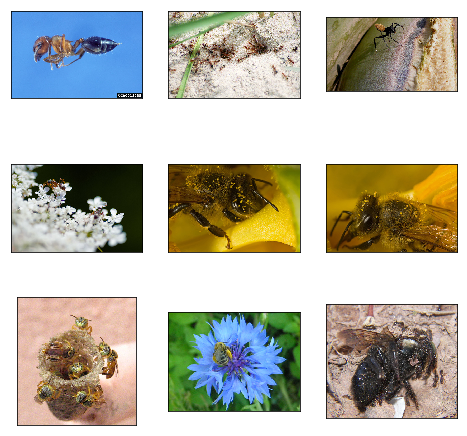

In [4]:
root_path = './data/hymenoptera_data/train/'
im_list = [os.path.join(root_path, 'ants', i) for i in os.listdir(root_path + 'ants')[:4]]
im_list += [os.path.join(root_path, 'bees', i) for i in os.listdir(root_path + 'bees')[:5]]
print(len(im_list))
nrows = 3
ncols = 3
figsize = (8, 8)

a,figs = plt.subplots(nrows, ncols, figsize=figsize)
#im_list,figs = plt.subplots(nrows, ncols, figsize=figsize)
print(type(_))
print(type(figs))
for i in range(nrows):
    for j in range(ncols):
        figs[i][j].imshow(Image.open(im_list[nrows*i+j]))
        figs[i][j].axes.get_xaxis().set_visible(False)
        figs[i][j].axes.get_yaxis().set_visible(False)
plt.show()

In [5]:
#定义数据预处理
train_tf = tfs.Compose([
    tfs.RandomResizedCrop(224),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #使用ImageNet的均值和方差
])

valid_tf = tfs.Compose([
    tfs.Resize(256),
    tfs.CenterCrop(224),
    tfs.ToTensor(),
    tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
#使用ImageFolder定义数据集
train_set = ImageFolder('./data/hymenoptera_data/train/', train_tf)
valid_set = ImageFolder('./data/hymenoptera_data/val/', valid_tf)
#使用DataLoader定义迭代器
train_data = DataLoader(train_set, 8, True, num_workers=2)
valid_data = DataLoader(valid_set, 16, False, num_workers=2)

In [7]:
#使用预训练的模型
net = models.resnet50(pretrained=True)  #安装的时候可能没有，但是会自动下载，90多M
print(net) #打印网络结构

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


In [8]:
#微调，将最后的全连接层改为2分类
net.fc = nn.Linear(2048, 2)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)

In [10]:
from utils import train
train(net, train_data, valid_data, 20 ,optimizer, criterion)

F:\Notebook\pytorch_learning\utils.py:52: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  im = Variable(im.cuda(), volatile=True)
F:\Notebook\pytorch_learning\utils.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label.cuda(), volatile=True)


Epoch 0. Train Loss: 0.532605, Train Acc: 0.762097, Valid Loss: 0.154066, Valid Acc: 0.951389, Time 00:00:09
Epoch 1. Train Loss: 0.388911, Train Acc: 0.826613, Valid Loss: 0.322798, Valid Acc: 0.868750, Time 00:00:11
Epoch 2. Train Loss: 0.233746, Train Acc: 0.891129, Valid Loss: 0.122865, Valid Acc: 0.945139, Time 00:00:10
Epoch 3. Train Loss: 0.284819, Train Acc: 0.854839, Valid Loss: 0.296055, Valid Acc: 0.871528, Time 00:00:10
Epoch 4. Train Loss: 0.345277, Train Acc: 0.875000, Valid Loss: 0.701429, Valid Acc: 0.737500, Time 00:00:10
Epoch 5. Train Loss: 0.244506, Train Acc: 0.939516, Valid Loss: 0.197503, Valid Acc: 0.915278, Time 00:00:10
Epoch 6. Train Loss: 0.161122, Train Acc: 0.951613, Valid Loss: 0.179141, Valid Acc: 0.926389, Time 00:00:10
Epoch 7. Train Loss: 0.095832, Train Acc: 0.963710, Valid Loss: 0.204456, Valid Acc: 0.927778, Time 00:00:10
Epoch 8. Train Loss: 0.290882, Train Acc: 0.891129, Valid Loss: 0.241571, Valid Acc: 0.920139, Time 00:00:10
Epoch 9. Train Loss

In [11]:
#将网络改为预测模式
net = net.eval()

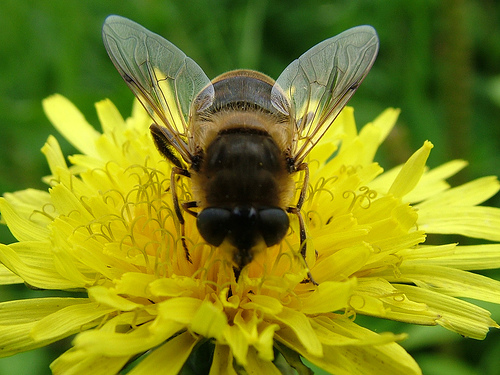

In [12]:
im1 = Image.open('./data/hymenoptera_data/train/bees/98391118_bdb1e80cce.jpg')
im1

In [14]:
im = valid_tf(im1)  #做数据预处理
out = net(Variable(im.unsqueeze(0)).cuda())
pred_label = out.max(1)[1].data[0]
print(pred_label)
print('predict label:{}'.format(train_set.classes[pred_label]))

tensor(1, device='cuda:0')
predict label:bees


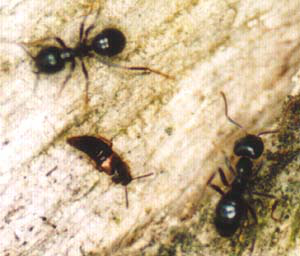

In [15]:
im2 = Image.open('./data/hymenoptera_data/train/ants/kurokusa.jpg')
im2

In [16]:
im = valid_tf(im2)  #做数据预处理
out = net(Variable(im.unsqueeze(0)).cuda())
pred_label = out.max(1)[1].data[0]
print('predict label:{}'.format(train_set.classes[pred_label]))

predict label:ants
